In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from astropy.table import Table
from slsim.image_simulation import (image_data_class, 
lens_image, rgb_image_from_image_list)

## Validation of image simulation in SLSim

Most of the functions in the image simulation take Lens class as an input. So, we need to

supply all the dc2 galaxy information in the form of Lens class. So, here we mimic Lens 

class only with necessary Lens class parts which are necessary for image simulation.

Before runing this notebook, please download all the data needed from the following link:

https://github.com/LSST-strong-lensing/data_public/tree/main/dp0_images_data_for_slsim_image_validation

Then, please change data path to your storage path.

In [2]:
## lens_class for validation
class Lens1(object):
    def __init__(self, kwargs_model, kwargs_lens, kwargs_source, 
    kwargs_lens_light, kwargs_ps):
        self.kwargs_model = kwargs_model
        self.kwargs_lens = kwargs_lens
        self.kwargs_source = kwargs_source
        self.kwargs_lens_light = kwargs_lens_light
        self.kwargs_ps = kwargs_ps

    def lenstronomy_kwargs(self, band=None):
        self.band = band
        kwargs_params = {
            "kwargs_lens": self.kwargs_lens,
            "kwargs_source": self.kwargs_source,
            "kwargs_lens_light": self.kwargs_lens_light,
            "kwargs_ps": self.kwargs_ps,
        }
        return self.kwargs_model, kwargs_params

class Lens2(object):
    def __init__(self, kwargs_model):
        self.kwargs_model = kwargs_model
    def lenstronomy_kwargs(self, band=None):
        return self.kwargs_model, None



## Let's get dc2 galaxy center in slsim image grid

In [3]:
kwargs_model = {'lens_light_model_list': ['SERSIC_ELLIPSE', 'SERSIC_ELLIPSE'],
  'lens_model_list': ['EPL', 'SHEAR', 'CONVERGENCE'],
  'source_light_model_list': ['SERSIC_ELLIPSE', 'SERSIC_ELLIPSE']}

In [4]:
kwarg_model=Lens2(kwargs_model)

In [5]:
data_class=image_data_class(
    kwarg_model, band="i", mag_zero_point=27, delta_pix=0.2, num_pix=35, 
    transform_pix2angle=np.array([[0.2, 0],[0, 0.2]])
)

In [6]:
galaxy_center_pix_x = 16.84335831
galaxy_center_pix_y = 16.52869664
center_cood_x, center_coord_y = data_class.map_pix2coord(galaxy_center_pix_x,
 galaxy_center_pix_y)

## Load dc2 galaxies

In [7]:
with open("/Users/narayankhadka/downloads/galaxy_sample_dc2.txt", 'rb') as file:
    # Use pickle.load() to load the data from the file
    dc2_galaxies = pickle.load(file)

In [8]:
dc2_galaxies = Table(dc2_galaxies)

In [9]:
dc2_galaxies[7]

sersic_disk,shear_1,ellipticity_2_bulge_true,size_minor_true,position_angle_true,ellipticity_true,size_minor_disk_true,size_disk_true,ra,ellipticity_bulge_true,ellipticity_1_true,dec,ellipticity_1_bulge_true,sersic_bulge,ellipticity_1_disk_true,convergence,ellipticity_disk_true,size_true,shear_2,ellipticity_2_disk_true,redshift,ellipticity_2_true,size_bulge_true,bulge_to_total_ratio_i,mag_true_g_lsst,mag_true_r_lsst,size_minor_bulge_true,mag_true_i_lsst,galaxy_id
float32,float64,float32,float64,float32,float32,float32,float64,float64,float32,float32,float64,float32,float32,float32,float64,float32,float64,float64,float32,float64,float32,float64,float32,float32,float32,float32,float32,int64
1.0,-0.0012687527231439732,-0.034115326,0.4717114800877277,-70.281845,0.053839747,0.72912425,0.8176907933955547,62.00273461841879,0.05370631,-0.04158212,-37.00827463174009,-0.041479062,4.0,-0.044221643,-0.004094584982031524,0.057257354,0.5253954914309595,0.0005450779706797707,-0.03637102,0.31266045186573765,-0.034200087,0.513994099718922,0.96235293,21.472523,20.070576,0.4615986,19.481592,7937608797


## Prepare lenstronomy kwargs from a dc2 galaxy
We select a galaxy centered at (ra, dec) =  (62.00273461841879, -37.00827463174009) 

degree. One can find image of this galaxy in DP0 data. We download image of this galaxy

from DP0 and compare it with image of the same galaxy silulated using slsim.

In [10]:
kwargs_lens = [{'theta_E': 1,
    'gamma': 2,
    'e1': dc2_galaxies[7]["ellipticity_1_true"],
    'e2': dc2_galaxies[7]["ellipticity_2_true"],
    'center_x': center_cood_x,
    'center_y':  center_coord_y},
   {'gamma1': dc2_galaxies[7]["shear_1"],
    'gamma2': dc2_galaxies[7]["shear_2"],
    'ra_0': 0,
    'dec_0': 0},
   {'kappa': dc2_galaxies[7]["convergence"], 'ra_0': 0, 'dec_0': 0}]
kwargs_source= None
flux_i = 10 ** (-dc2_galaxies[7]["mag_true_i_lsst"] / 2.5)
mag_bulge_i = -2.5 * np.log10(dc2_galaxies[7]["bulge_to_total_ratio_i"] * flux_i)
mag_disk_i = -2.5 * np.log10((1-dc2_galaxies[7]["bulge_to_total_ratio_i"]) * flux_i)
kwargs_lens_light_i = [{'magnitude': mag_bulge_i,
    'R_sersic': np.sqrt(
        dc2_galaxies[7]["size_minor_bulge_true"]*dc2_galaxies[7]["size_bulge_true"]),
    'n_sersic': 4.0,
    'e1': dc2_galaxies[7]["ellipticity_1_bulge_true"],
    'e2': dc2_galaxies[7]["ellipticity_2_bulge_true"],
    'center_x': center_cood_x,
    'center_y':  center_coord_y},
    {'magnitude': mag_disk_i,
    'R_sersic': np.sqrt(
        dc2_galaxies[7]["size_minor_disk_true"]*dc2_galaxies[7]["size_disk_true"]),
    'n_sersic': 1.0,
    'e1': dc2_galaxies[7]["ellipticity_1_disk_true"],
    'e2': dc2_galaxies[7]["ellipticity_2_disk_true"],
    'center_x': center_cood_x,
    'center_y':  center_coord_y}]
flux_r = 10 ** (-dc2_galaxies[7]["mag_true_r_lsst"] / 2.5)
mag_bulge_r = -2.5 * np.log10(dc2_galaxies[7]["bulge_to_total_ratio_i"] * flux_r)
mag_disk_r = -2.5 * np.log10((1-dc2_galaxies[7]["bulge_to_total_ratio_i"]) * flux_r)
kwargs_lens_light_r = [{'magnitude': mag_bulge_r,
    'R_sersic': np.sqrt(
        dc2_galaxies[7]["size_minor_bulge_true"]*dc2_galaxies[7]["size_bulge_true"]),
    'n_sersic': 4.0,
    'e1': dc2_galaxies[7]["ellipticity_1_bulge_true"],
    'e2': dc2_galaxies[7]["ellipticity_2_bulge_true"],
    'center_x': center_cood_x,
    'center_y':  center_coord_y}, 
    {'magnitude': mag_disk_r,
    'R_sersic': np.sqrt(
        dc2_galaxies[7]["size_minor_disk_true"]*dc2_galaxies[7]["size_disk_true"]),
    'n_sersic': 1.0,
    'e1': dc2_galaxies[7]["ellipticity_1_disk_true"],
    'e2': dc2_galaxies[7]["ellipticity_2_disk_true"],
    'center_x': center_cood_x,
    'center_y':  center_coord_y}]
flux_g = 10 ** (-dc2_galaxies[7]["mag_true_g_lsst"] / 2.5)
mag_bulge_g = -2.5 * np.log10(dc2_galaxies[7]["bulge_to_total_ratio_i"] * flux_g)
mag_disk_g = -2.5 * np.log10((1-dc2_galaxies[7]["bulge_to_total_ratio_i"]) * flux_g)
kwargs_lens_light_g = [{'magnitude': mag_bulge_g,
    'R_sersic': np.sqrt(
        dc2_galaxies[7]["size_minor_bulge_true"]*dc2_galaxies[7]["size_bulge_true"]),
    'n_sersic': 4.0,
    'e1': dc2_galaxies[7]["ellipticity_1_bulge_true"],
    'e2': dc2_galaxies[7]["ellipticity_2_bulge_true"],
    'center_x': center_cood_x,
    'center_y':  center_coord_y}, 
    {'magnitude': mag_disk_g,
    'R_sersic': np.sqrt(
        dc2_galaxies[7]["size_minor_disk_true"]*dc2_galaxies[7]["size_disk_true"]),
    'n_sersic': 1.0,
    'e1': dc2_galaxies[7]["ellipticity_1_disk_true"],
    'e2': dc2_galaxies[7]["ellipticity_2_disk_true"],
    'center_x': center_cood_x,
    'center_y':  center_coord_y}]
kwargs_ps = None

## Initiate Lens class for each band

In [11]:
lens_class_i = Lens1(kwargs_model, kwargs_lens, kwargs_source, 
kwargs_lens_light_i, kwargs_ps)
lens_class_r = Lens1(kwargs_model, kwargs_lens, kwargs_source, 
kwargs_lens_light_r, kwargs_ps)
lens_class_g = Lens1(kwargs_model, kwargs_lens, kwargs_source, 
kwargs_lens_light_g, kwargs_ps)

## Load psf and variance map for a dc2 galaxy

In [12]:
psf_kernel_i = np.load("/Users/narayankhadka/downloads/dc2_galaxy_kernel_i.npy")
psf_kernel_r = np.load("/Users/narayankhadka/downloads/dc2_galaxy_kernel_r.npy")
psf_kernel_g = np.load("/Users/narayankhadka/downloads/dc2_galaxy_kernel_g.npy")

In [13]:
dc2_galaxy_variance_i = np.sqrt(
    np.load("/Users/narayankhadka/downloads/dc2_galaxy_variance_i.npy"))
dc2_galaxy_variance_g = np.sqrt(
    np.load("/Users/narayankhadka/downloads/dc2_galaxy_variance_g.npy"))
dc2_galaxy_variance_r = np.sqrt(
    np.load("/Users/narayankhadka/downloads/dc2_galaxy_variance_r.npy"))

## Simulate image of a dc2 galaxy using slsim

In [14]:
dc2_galaxy_image_from_slsim_i=lens_image(
    lens_class_i,
    band="i",
    mag_zero_point=27,
    num_pix = 35,
    psf_kernel = psf_kernel_i,
    transform_pix2angle = np.array([[0.2, 0], [0, 0.2]]),
    exposure_time=None,
    t_obs=None,
    std_gaussian_noise=dc2_galaxy_variance_i,
    with_source=False,
    with_deflector=True,
)
dc2_galaxy_image_from_slsim_g=lens_image(
    lens_class_g,
    band="g",
    mag_zero_point=27,
    num_pix = 35,
    psf_kernel = psf_kernel_g,
    transform_pix2angle = np.array([[0.2, 0], [0, 0.2]]),
    exposure_time=None,
    t_obs=None,
    std_gaussian_noise=dc2_galaxy_variance_g,
    with_source=False,
    with_deflector=True,
)
dc2_galaxy_image_from_slsim_r=lens_image(
    lens_class_r,
    band="r",
    mag_zero_point=27,
    num_pix = 35,
    psf_kernel = psf_kernel_r,
    transform_pix2angle = np.array([[0.2, 0], [0, 0.2]]),
    exposure_time=None,
    t_obs=None,
    std_gaussian_noise=dc2_galaxy_variance_r,
    with_source=False,
    with_deflector=True,
)


/Users/narayankhadka/lenstronomy/lenstronomy/Data/psf.py:80: UserWarning: Input PSF model has at least one negative element, which is unphysical except for a PSF of an interferometric array.
  warnings.warn(
/Users/narayankhadka/lenstronomy/lenstronomy/Data/psf.py:80: UserWarning: Input PSF model has at least one negative element, which is unphysical except for a PSF of an interferometric array.
  warnings.warn(


## Load dc2 galaxy image from DP0

In [15]:
dc2_galaxy_image_from_dp0_i = np.load(
    "/Users/narayankhadka/downloads/dc2_galaxy_i.npy")
dc2_galaxy_image_from_dp0_r = np.load(
    "/Users/narayankhadka/downloads/dc2_galaxy_r.npy")
dc2_galaxy_image_from_dp0_g = np.load(
    "/Users/narayankhadka/downloads/dc2_galaxy_g.npy")


## Compute the difference between slsim and DP0 
## images of the same galaxy

In [16]:
diff_i = dc2_galaxy_image_from_slsim_i-dc2_galaxy_image_from_dp0_i
diff_r = dc2_galaxy_image_from_slsim_r-dc2_galaxy_image_from_dp0_r
diff_g = dc2_galaxy_image_from_slsim_g-dc2_galaxy_image_from_dp0_g

## Plot images and residual in i-band

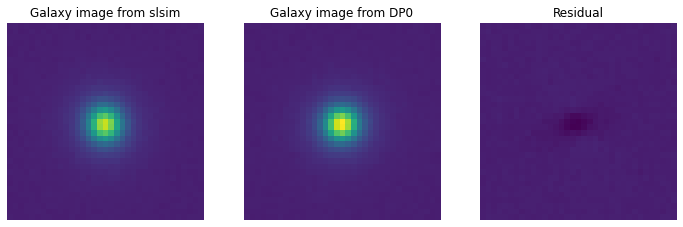

In [17]:
#This is a comparision of an image of a galaxy from DP0 at 
#(ra, dec)= (62.00273461841879, -37.00827463174009) degree. This comparision is in
# i-band.
global_min = min(dc2_galaxy_image_from_slsim_i.min(), dc2_galaxy_image_from_dp0_i.min(),
 diff_i.min())
global_max = max(dc2_galaxy_image_from_slsim_i.max(), dc2_galaxy_image_from_dp0_i.max(),
 diff_i.max())
# Plotting the images
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(dc2_galaxy_image_from_slsim_i, origin="lower", 
           vmin=global_min, vmax=global_max) 
plt.title('Galaxy image from slsim')
plt.axis('off')  # Turn off axis labels

plt.subplot(1, 3, 2)
plt.imshow(dc2_galaxy_image_from_dp0_i, origin="lower", 
           vmin=global_min, vmax=global_max)
plt.title('Galaxy image from DP0')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(diff_i, origin="lower", vmin=global_min, vmax=global_max)
plt.title('Residual')
plt.axis('off')

plt.show()


## Visualize these images in RGB color

In [18]:
slsim_image_list = [dc2_galaxy_image_from_slsim_i, dc2_galaxy_image_from_slsim_r,
                     dc2_galaxy_image_from_slsim_g]

In [19]:
slsim_rgb_image=rgb_image_from_image_list(image_list=slsim_image_list, stretch=0.5)

In [20]:
dp0_image_list = [dc2_galaxy_image_from_dp0_i, 
                  dc2_galaxy_image_from_dp0_r,dc2_galaxy_image_from_dp0_g]

In [21]:
dp0_rgb_image=rgb_image_from_image_list(image_list=dp0_image_list, stretch=0.5)

In [84]:
diff_list = [diff_i, diff_r, diff_g]

In [85]:
rgb_diff=rgb_image_from_image_list(image_list=diff_list, stretch=0.5)

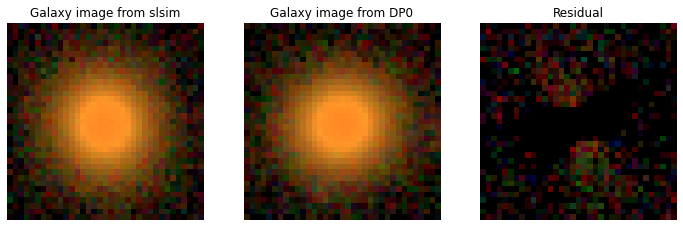

In [86]:
#This is a comparision of an image of galaxy from DP0 at 
#(ra, dec)= (62.00273461841879, -37.00827463174009) degree.
global_min = min(slsim_rgb_image.min(), dp0_rgb_image.min(),
 rgb_diff.min())
global_max = max(slsim_rgb_image.max(), dp0_rgb_image.max(),
 rgb_diff.max())
# Plotting the images
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(slsim_rgb_image, origin="lower", vmin=global_min, vmax=global_max) 
plt.title('Galaxy image from slsim')
plt.axis('off')  # Turn off axis labels

plt.subplot(1, 3, 2)
plt.imshow(dp0_rgb_image, origin="lower", vmin=global_min, vmax=global_max)
plt.title('Galaxy image from DP0')
plt.axis('off')


plt.subplot(1, 3, 3)
plt.imshow(rgb_diff, origin="lower",
            vmin=global_min, vmax=global_max)
plt.title('Residual')
plt.axis('off')

plt.show()


## Let's simulate an image of a DC2 galaxy using DP0
## cutout for background noise and exposure map for 
## poisson noise.

In above method, we directly used variance map to simulate DP0 background noise. Now,

we simulate an image of the same galaxy with the different approach. Here, we take a

DP0 cutout close to the galaxy image and we use this cutout as a background noise for

our simulation. We take the exposure map of the DP0 galaxy image with specified pixel

size and use this exposure map to generate poisson noise for our simulated image.

Finally, our simulated image have both background noise from DC2 data and poisson noise.

This is the approach we use in lens injection in DP0 field.

In [24]:
## These are DP0 cutouts close to the dp0 galaxy which we want to simulate using slsim.
dc2_galaxy_background_i = np.load("/Users/narayankhadka/downloads/dc2_background_i.npy")
dc2_galaxy_background_g = np.load("/Users/narayankhadka/downloads/dc2_background_g.npy")
dc2_galaxy_background_r = np.load("/Users/narayankhadka/downloads/dc2_background_r.npy")

## These are exposure map of the dp0 galaxy with in (35, 35) pixel size.
dc2_galaxy_exposure_i = np.load(
    "/Users/narayankhadka/downloads/dc2_exposure_time_i.npy")
dc2_galaxy_exposure_g = np.load(
    "/Users/narayankhadka/downloads/dc2_exposure_time_g.npy")
dc2_galaxy_exposure_r = np.load(
    "/Users/narayankhadka/downloads/dc2_exposure_time_r.npy")

In [75]:
## Here we simulate galaxy image using slsim and this includes poisson noise.
dc2_galaxy_image_from_slsim_i_2=lens_image(
    lens_class_i,
    band="i",
    mag_zero_point=27,
    num_pix = 35,
    psf_kernel = psf_kernel_i,
    transform_pix2angle = np.array([[0.2, 0], [0, 0.2]]),
    exposure_time=dc2_galaxy_exposure_i,
    t_obs=None,
    std_gaussian_noise=None,
    with_source=False,
    with_deflector=True,
)
dc2_galaxy_image_from_slsim_g_2=lens_image(
    lens_class_g,
    band="g",
    mag_zero_point=27,
    num_pix = 35,
    psf_kernel = psf_kernel_g,
    transform_pix2angle = np.array([[0.2, 0], [0, 0.2]]),
    exposure_time=dc2_galaxy_exposure_g,
    t_obs=None,
    std_gaussian_noise=None,
    with_source=False,
    with_deflector=True,
)
dc2_galaxy_image_from_slsim_r_2=lens_image(
    lens_class_r,
    band="r",
    mag_zero_point=27,
    num_pix = 35,
    psf_kernel = psf_kernel_r,
    transform_pix2angle = np.array([[0.2, 0], [0, 0.2]]),
    exposure_time=dc2_galaxy_exposure_r,
    t_obs=None,
    std_gaussian_noise=None,
    with_source=False,
    with_deflector=True,
)

In [76]:
# Let's add dp0 background/cutouts to the simulated galaxy image
dc2_galaxy_image_from_slsim_with_dp0_background_cutout_i = (
    dc2_galaxy_image_from_slsim_i_2 + dc2_galaxy_background_i)
dc2_galaxy_image_from_slsim_with_dp0_background_cutout_g = (
    dc2_galaxy_image_from_slsim_g_2 + dc2_galaxy_background_g)
dc2_galaxy_image_from_slsim_with_dp0_background_cutout_r = (
    dc2_galaxy_image_from_slsim_r_2 + dc2_galaxy_background_r)

In [77]:
## compute the difference between dp0 image and slsim image in each band
diff_i_n = (
dc2_galaxy_image_from_slsim_with_dp0_background_cutout_i-dc2_galaxy_image_from_dp0_i)
diff_r_n = (
dc2_galaxy_image_from_slsim_with_dp0_background_cutout_r-dc2_galaxy_image_from_dp0_r)
diff_g_n = (
dc2_galaxy_image_from_slsim_with_dp0_background_cutout_g-dc2_galaxy_image_from_dp0_g)

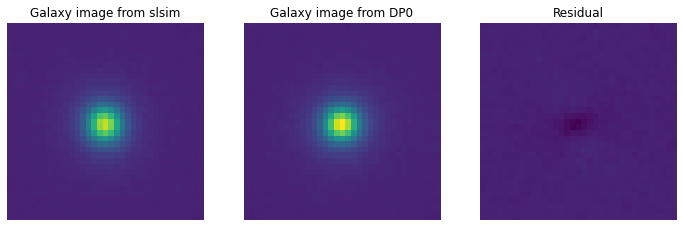

In [78]:
#This is a comparision of an image of galaxy from DP0 at 
#(ra, dec)= (62.00273461841879, -37.00827463174009) degree.
global_min = min(dc2_galaxy_image_from_slsim_with_dp0_background_cutout_i.min(), 
                 dc2_galaxy_image_from_dp0_i.min(), diff_i_n.min())
global_max = max(dc2_galaxy_image_from_slsim_with_dp0_background_cutout_i.max(), 
                 dc2_galaxy_image_from_dp0_i.max(), diff_i_n.max())
# Plotting the images
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(dc2_galaxy_image_from_slsim_with_dp0_background_cutout_i, origin="lower", 
           vmin=global_min, vmax=global_max) 
plt.title('Galaxy image from slsim')
plt.axis('off')  # Turn off axis labels

plt.subplot(1, 3, 2)
plt.imshow(dc2_galaxy_image_from_dp0_i, origin="lower", 
           vmin=global_min, vmax=global_max)
plt.title('Galaxy image from DP0')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(diff_i_n, origin="lower", vmin=global_min, vmax=global_max)
plt.title('Residual')
plt.axis('off')

plt.show()


In [79]:
## Produce RGB color image for slsim
slsim_image_list_n = [dc2_galaxy_image_from_slsim_with_dp0_background_cutout_i, 
                      dc2_galaxy_image_from_slsim_with_dp0_background_cutout_r,
                     dc2_galaxy_image_from_slsim_with_dp0_background_cutout_g]

slsim_rgb_image_n=rgb_image_from_image_list(image_list=slsim_image_list_n, stretch=0.5)

In [80]:
diff_n_list=[diff_i_n, diff_r_n, diff_g_n]

In [81]:
rgb_diff_nn=rgb_image_from_image_list(image_list=diff_n_list, stretch=0.5)

In [82]:
## Difference between slsim and dp0 rgb images
rgb_diff_n=slsim_rgb_image_n-dp0_rgb_image

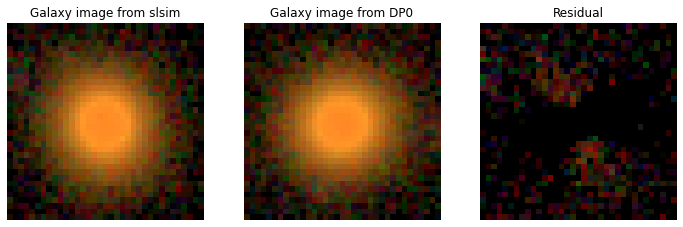

In [83]:
#This is a comparision of an image of galaxy from DP0 at 
#(ra, dec)= (62.00273461841879, -37.00827463174009) degree.
global_min = min(slsim_rgb_image_n.min(), dp0_rgb_image.min(),
 rgb_diff_n.min())
global_max = max(slsim_rgb_image_n.max(), dp0_rgb_image.max(),
 rgb_diff_n.max())
# Plotting the images
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(slsim_rgb_image_n, origin="lower", vmin=global_min, vmax=global_max) 
plt.title('Galaxy image from slsim')
plt.axis('off')  # Turn off axis labels

plt.subplot(1, 3, 2)
plt.imshow(dp0_rgb_image, origin="lower", vmin=global_min, vmax=global_max)
plt.title('Galaxy image from DP0')
plt.axis('off')


plt.subplot(1, 3, 3)
plt.imshow(rgb_diff_nn, origin="lower", vmin=global_min,
            vmax=global_max)
plt.title('Residual')
plt.axis('off')

plt.show()